# Part 2: Time Series Modeling

In this notebook, you will implement functions to extract features from time series data and build ARIMA models.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pathlib import Path
import os

# Set style for plots
#plt.style.use('seaborn')
%matplotlib inline

## 1. Feature Extraction

Implement the `extract_time_series_features` function to calculate rolling window features.

In [2]:
def extract_time_series_features(data, window_size=60):
    """Extract rolling window features from time series data.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    window_size : int
        Size of the rolling window in seconds
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing extracted features for each signal
    """
    # 1. Calculate rolling window statistics
    # 2. Include mean, std, min, max, and autocorrelation
    #setting timestamp as the index
    data.set_index('timestamp', inplace=True)
    features = []
    phys_signals = ['heart_rate', 'eda', 'temperature']

    #loop through phys_signals to calculate the rolling window statistics
    for signal in phys_signals:
        rolling_window = data[signal].rolling(window=window_size, min_periods = 1)
        mean = rolling_window.mean()
        std = rolling_window.std()
        min = rolling_window.min()
        max = rolling_window.max()

        #calculating autocorrelation statistic
        autocorr = data[signal].rolling(window=window_size, min_periods=1).apply(lambda x: x.autocorr(lag=1), raw=False)
        features.append(mean.rename(f'{signal}_mean'))
        features.append(std.rename(f'{signal}_std'))
        features.append(min.rename(f'{signal}_min'))
        features.append(max.rename(f'{signal}_max'))
        features.append(autocorr.rename(f'{signal}_autocorr'))
    df_feature = pd.concat(features, axis = 1)
    return df_feature

    

In [4]:
data = pd.read_csv('data/processed/S1_processed.csv')
features = extract_time_series_features(data, window_size=60)
print(features.head())

/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


                           heart_rate_mean  heart_rate_std  heart_rate_min  \
timestamp                                                                    
2018-12-05 16:28:57+00:00           108.28             NaN          108.28   
2018-12-05 16:28:58+00:00           108.28             0.0          108.28   
2018-12-05 16:28:59+00:00           108.28             0.0          108.28   
2018-12-05 16:29:00+00:00           108.28             0.0          108.28   
2018-12-05 16:29:01+00:00           108.28             0.0          108.28   

                           heart_rate_max  heart_rate_autocorr  eda_mean  \
timestamp                                                                  
2018-12-05 16:28:57+00:00          108.28                  NaN  0.011852   
2018-12-05 16:28:58+00:00          108.28                  NaN  0.017458   
2018-12-05 16:28:59+00:00          108.28                  NaN  0.019540   
2018-12-05 16:29:00+00:00          108.28                  1.0  0.020501 

## 2. ARIMA Modeling

Implement the `build_arima_model` function to fit ARIMA models and generate diagnostic plots.

In [5]:
def build_arima_model(series, order=(1,1,1), output_dir='plots'):
    """Fit an ARIMA model to the time series and generate diagnostic plots.
    
    Parameters
    ----------
    series : pd.Series
        Time series data to model
    order : tuple
        (p,d,q) order of the ARIMA model
    output_dir : str
        Directory to save diagnostic plots
        
    Returns
    -------
    statsmodels.tsa.arima.model.ARIMAResults
        Fitted ARIMA model
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Fit ARIMA model
    model = ARIMA(series, order=order)
    fitted_arima = model.fit()
    # 2. Generate diagnostic plots:
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    #    - Model fit plot
    axes[0].plot(series, label='Original')
    axes[0].plot(fitted_arima.fittedvalues, label='Fitted', alpha=0.7)
    axes[0].set_title('ARIMA Model')
    axes[0].legend()
    #    - Residuals plot
    residuals = fitted_arima.resid
    axes[1].plot(residuals)
    axes[1].set_title('Residuals')
    #    - Forecast plot
    forecast = fitted_arima.forecast(steps=30)
    axes[2].plot(series, label='Original')
    forecast_index = pd.date_range(start=series.index[-1], periods=30, freq='s')
    axes[2].plot(forecast_index, forecast, label='Forecast', linestyle='--')
    axes[2].set_title('Forecast')
    axes[2].legend()
    # 3. Save plots to output directory
    plt.tight_layout()
    plot_path = os.path.join(output_dir, f'arima_diagnostics_{series.name or "series"}.png')
    plt.savefig(plot_path)
    return fitted_arima

    

/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq

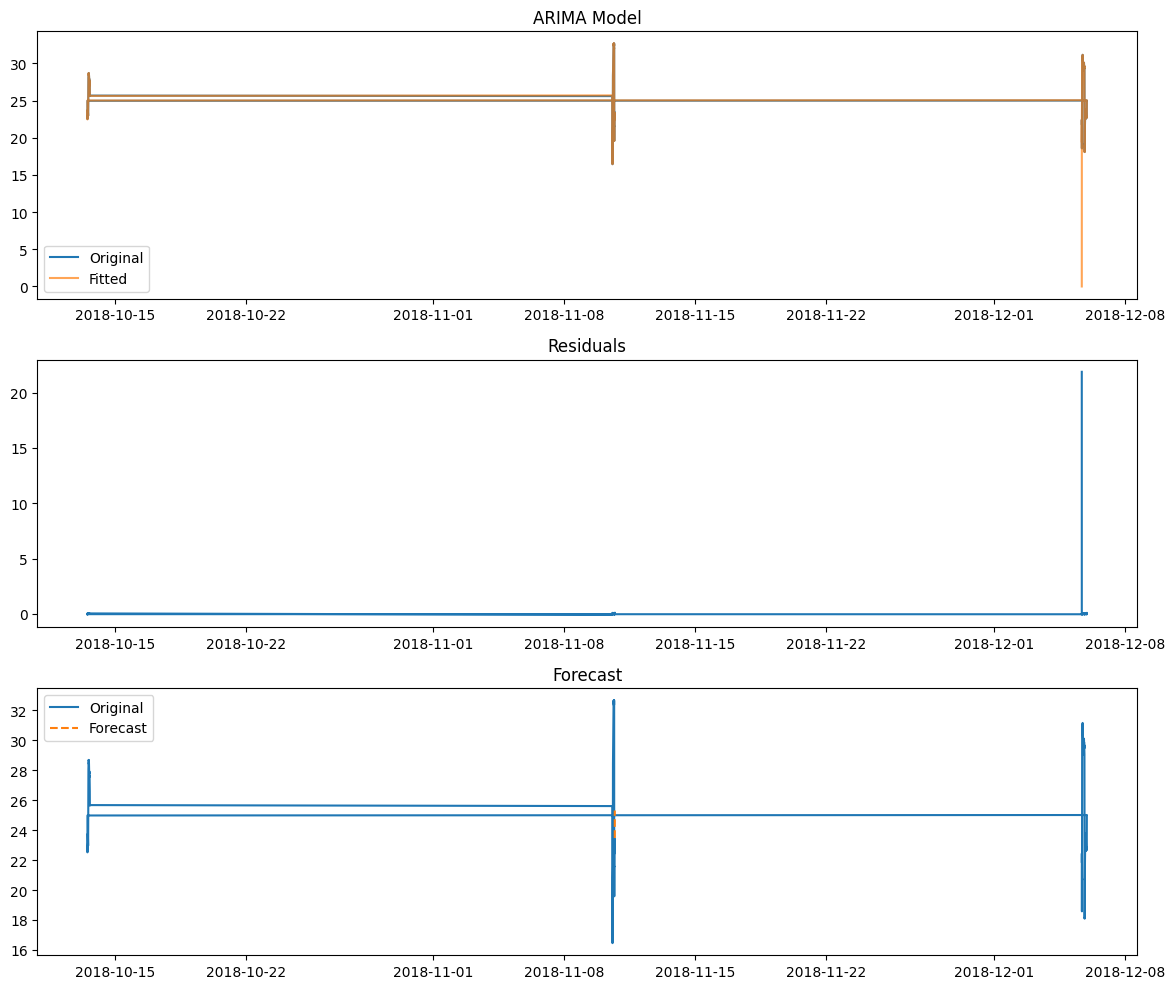

In [8]:
series = features['temperature_mean'].copy()
series.index = pd.to_datetime(series.index)
build_arima_model(series, order=(1,1,1), output_dir='plots')